In [1]:
#@title import packages
import keras
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
from sklearn.metrics import *
import rioxarray as rxr

  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-koh3i9ay
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-koh3i9ay
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.7 MB/s eta 0:00:00:00:01
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34377 sha256=a64d6eb4d1aa1f9534455aa52d34a76

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
base_dir = r"/content/gdrive/MyDrive/mudtrain/"
#@title Read training images and normalise
training_images_list = os.listdir(r"{}train/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  training_masks_list.append(n)
  a = (np.array(rxr.open_rasterio(r"{}train/images/{}".format(base_dir,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images.append(a)

## Training masks
training_masks = []
for n in training_masks_list:
  a = (np.array(rxr.open_rasterio(r"{}train/labels/{}".format(base_dir,n))))
  training_masks.append(a)

## Validation images
validation_images_list = os.listdir(r"{}val/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  validation_masks_list.append(n)
  a = (np.array(rxr.open_rasterio(r"{}val/images/{}".format(base_dir,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images.append(a)

## Validation masks
validation_masks = []
for n in validation_masks_list:
  a = (np.array(rxr.open_rasterio(r"{}val/labels/{}".format(base_dir,n))))
  validation_masks.append(a)

In [3]:
#@title Pre-process data, reshaping and transposing
for i in range(len(training_images)):
  training_images[i] = training_images[i].astype('float32')
  training_images[i] = training_images[i].T

for i in range(len(training_masks)):
  training_masks[i] = training_masks[i].reshape(1,256,256)
  training_masks[i] = training_masks[i].T

for i in range(len(validation_images)):
  validation_images[i] = validation_images[i].astype('float32')
  validation_images[i] = validation_images[i].T

for i in range(len(validation_masks)):
  validation_masks[i] = validation_masks[i].reshape(1,256,256)
  validation_masks[i] = validation_masks[i].T


for i in range(len(training_images)):
  training_images[i] = training_images[i].reshape(256,256,10)

for i in range(len(validation_images)):
  validation_images[i] = validation_images[i].reshape(256,256,10)



In [14]:
## Test images
test_dir=r'/content/gdrive/MyDrive/mudtest/'
test_images_list = os.listdir(r"{}/images/".format(test_dir))
test_masks_list = []
test_images = []
for n in test_images_list:
  test_masks_list.append(n)
  a = (np.array(rxr.open_rasterio(r"{}/images/{}".format(test_dir,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images.append(a)

## Test masks
test_masks = []
for n in test_masks_list:
  a = (np.array(rxr.open_rasterio(r"{}/labels/{}".format(test_dir,n))))
  test_masks.append(a)

In [15]:
for i in range(len(test_images)):
  test_images[i] = test_images[i].astype('float32')
  test_images[i] = test_images[i].T

for i in range(len(test_masks)):
  test_masks[i] = test_masks[i].reshape(1,256,256,1)
  test_masks[i] = test_masks[i].T
for i in range(len(test_images)):
  test_images[i] = test_images[i].reshape(-1,256,256,10)

In [21]:
len(test_images)

266

In [4]:
images=np.vstack([training_images])
val_images=np.vstack([validation_images])
images.shape

(889, 256, 256, 10)

In [5]:
masks=np.vstack([training_masks])
val_masks=np.vstack([validation_masks])
val_masks.shape

(223, 256, 256, 1)

In [6]:
import gc
del training_images,validation_images,training_masks,validation_masks,training_images_list,validation_images_list,
training_masks_list,validation_masks_list,test_masks_list,test_images_list,test_images,test_masks
gc.collect()

889

In [11]:
del unet

In [13]:
del images,masks,val_images,val_masks

In [7]:
#@title boundary_loss
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

#Shape of semantic segmentation mask
OUTPUT_SHAPE = (256, 256, 1)
def boundary_loss(y_true, y_pred):

    """
    Paper Implemented : https://arxiv.org/abs/1905.07852
    Using Binary Segmentation mask, generates boundary mask on fly and claculates boundary loss.
    :param y_true:
    :param y_pred:
    :return:
    """
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.cast(y_pred,tf.float32)
    
    y_pred_bd = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_pred)
    y_true_bd = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_true)
    y_pred_bd = y_pred_bd - (1 - y_pred)
    y_true_bd = y_true_bd - (1 - y_true)

    y_pred_bd_ext = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_pred)
    y_true_bd_ext = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', input_shape=OUTPUT_SHAPE)(1 - y_true)
    y_pred_bd_ext = y_pred_bd_ext - (1 - y_pred)
    y_true_bd_ext = y_true_bd_ext - (1 - y_true)

    P = K.sum(y_pred_bd * y_true_bd_ext) / K.sum(y_pred_bd) + 1e-7
    R = K.sum(y_true_bd * y_pred_bd_ext) / K.sum(y_true_bd) + 1e-7
    F1_Score = 2 * P * R / (P + R + 1e-7)
    loss = K.mean(1 - F1_Score)  
    return loss



In [8]:
from keras.callbacks import ModelCheckpoint, Callback

class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

In [9]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* binary_crossentropy(y_true, y_pred) +  (1-alpha)* boundary_loss(y_true, y_pred)
    return gl_sl

In [7]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=True): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

#Simple U-NET
def unetmodel(input_shape, dropout=0, batchnorm=True):    
    
    filters = [32,64, 128, 256,512]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers   
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])     
    return model

In [8]:
from keras import metrics
unet= unetmodel(input_shape=(256,256,10))
#gl_sl_wrapper(alpha)
unet.compile(optimizer = adam_v2.Adam(learning_rate = 1e-4), loss =binary_crossentropy, metrics = ['accuracy'])
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  2912        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
# Train model
from keras.callbacks import ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                         factor=0.1,
                         patience=10,
                         verbose=1,
                         mode='auto',
                         min_delta=0.00003,
                         cooldown=0,
                         min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,verbose=1,mode='min')
save_model= ModelCheckpoint('unet_bce.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
unet.fit(images, masks, validation_data=(val_images,val_masks), batch_size=16, epochs=1000,verbose=1,shuffle=True,callbacks=[save_model,reduce_lr,early_stop])

Epoch 1/1000
56/56 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.9033
Epoch 1: val_loss improved from inf to 0.59373, saving model to unet_bce.hdf5
56/56 [==============================] - 25s 299ms/step - loss: 0.4356 - accuracy: 0.9033 - val_loss: 0.5937 - val_accuracy: 0.7385 - lr: 1.0000e-04
Epoch 2/1000
56/56 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.9563
Epoch 2: val_loss did not improve from 0.59373
56/56 [==============================] - 12s 217ms/step - loss: 0.3898 - accuracy: 0.9563 - val_loss: 0.6319 - val_accuracy: 0.6638 - lr: 1.0000e-04
Epoch 3/1000
56/56 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.9598
Epoch 3: val_loss did not improve from 0.59373
56/56 [==============================] - 12s 217ms/step - loss: 0.3836 - accuracy: 0.9598 - val_loss: 0.6063 - val_accuracy: 0.7191 - lr: 1.0000e-04
Epoch 4/1000
56/56 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.96

In [10]:
np.save('unet_bce-history.npy',unet.history.history)

In [11]:
# model = load_model('daunet_325.hdf5',custom_objects={'bce_iou_hybrid_loss': bce_iou_hybrid_loss})
model_history = np.load('unet_bce-history.npy', allow_pickle='TRUE').item()

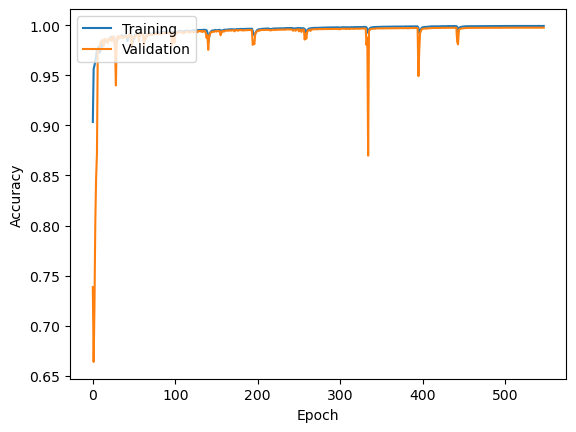

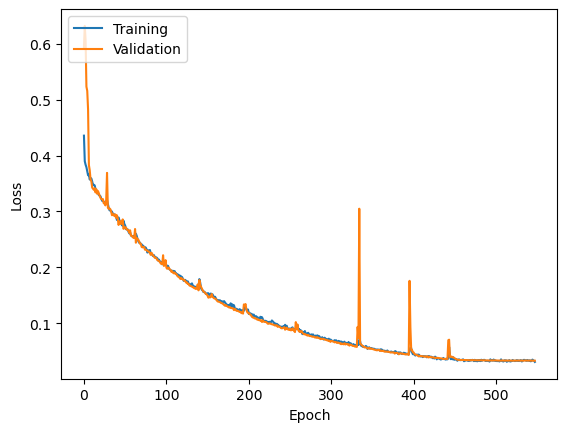

In [12]:
#@title Plot accuracy and loss 
from matplotlib import pyplot as plt
## Accuracy
plt.plot(model_history['accuracy'])
plt.plot(model_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [16]:
#@title Returns an image or array plot of mask prediction

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [17]:
#@title Metric functions for evaluation
def accuracy_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()
    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    accuracy = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 256, 256, 10))
      reconstruction = np.round(reconstruction).flatten()
      accuracy.append(accuracy_score(mask[i].flatten(), reconstruction))
    return accuracy

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='binary'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='binary'))

    return precision

def iou_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return jaccard_score(mask.flatten(), reconstruction, average='binary')

  else: # If a list of images input, find accuracy for each
    iou = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        iou.append(jaccard_score(mask[i].flatten(), reconstruction, average='binary'))

    return iou

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)


In [18]:
accuracy = (accuracy_eval(unet, test_images, test_masks))
precision = (precision_eval(unet, test_images, test_masks))
recall = (recall_eval(unet, test_images, test_masks))
iou = (iou_eval(unet, test_images, test_masks))

1/1 [==============================] - 0s 22ms/step


In [19]:
f1_score = (f1_score_eval_basic(precision, recall))

In [20]:

# Print score eval results for each model
print('model accuracy: ', np.mean(accuracy), np.std(accuracy))
# Print precision eval results for each model
print('model precision: ', np.mean(precision), np.std(precision))
# Print recall eval results for each model
print('model recall: ', np.mean(recall), np.std(recall))
# Print f1-score eval results for each model
print('model F1-score: ', np.mean(f1_score))
print('model iou: ', np.mean(iou))

model accuracy:  0.98225328259002 0.0193894454217881
model precision:  0.9424929817805804 0.10842287133369483
model recall:  0.9784169042228712 0.03561059231296698
model F1-score:  0.9601190271388728
model iou:  0.9239982009541337
